All the modules used in creating this notebook is open-source and free.

The proposed solution to the tagging of exceptions and it's self-healing process has been implemented in the following manner. 

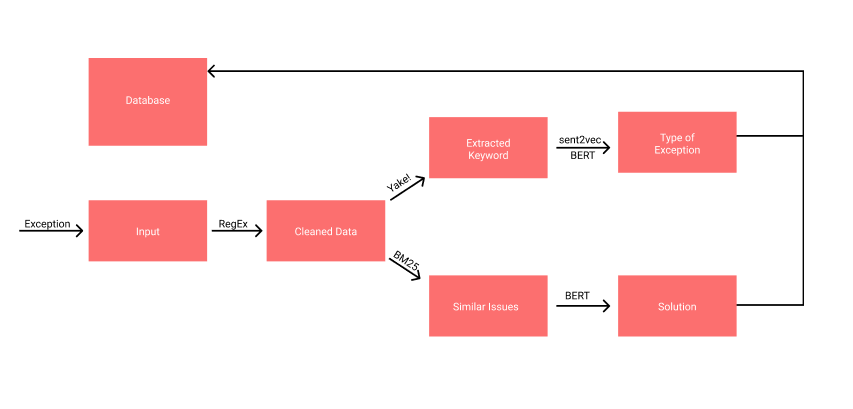

This notebook consists of the following sections as the implemenation of above architecture: 

1. Data cleaning 
2. Keyword Extraction 
3. Keyword Classification
4. Similar Issues Extraction
5. Finding Solution


# Reading and Analyzing data

In [ ]:
#reading the excel file
import pandas as pd
dfs = pd.read_excel('/content/Datasets EY GDS.xlsx')

In [ ]:
#reading the input sheet
input = pd.read_excel('/content/Datasets EY GDS.xlsx', sheet_name='Input')

In [ ]:
#reading top five rows of input sheet
input.head()

,Exception (input),Queue,Process
0,Invite not found in both CBS mailbox,Queue-12,Process-9
1,Interviewer xxxx mail ID not found in invite.,Queue-12,Process-9
2,Invite not found in both TAX and PAS mailbox,Queue-12,Process-9
3,InternalFailed to evaluate expression 'Replace...,Queue-14,Process-11
4,Could not execute code stage because exception...,Queue-16,Process-13


In [ ]:
#reading the sheets which consists of keywords for tagging
tag = pd.read_excel('/content/Datasets EY GDS.xlsx', sheet_name='Keywords for tagging')

In [ ]:
#reading top five rows of the keywords for tagging 
tag.head()

,Keywords for System Exception,Keywords for Business Exception
0,Unable to launch service,Missing the mandatory fields
1,Failed to fetch data,Mail Id not found
2,Failed fetching Site issue,Invite is not found
3,Code stage not executed,Template is not found
4,Exception occured in processing,Error in Input File


In [ ]:
#reading the train dataset
train = pd.read_excel('/content/Datasets EY GDS.xlsx', sheet_name='Training Data ')
train.head()

,Exception (input),Queue,Process,Exception Category (ouput),Solution
0,Invite not found in both CBS mailbox,Queue-12,Process-9,Business Exception,Lorem Ipsum is simply dummy text of the printi...
1,Interviewer xxxx mail ID not found in invite.,Queue-12,Process-9,Business Exception,Lorem Ipsum is simply dummy text of the printi...
2,Invite not found in both TAX and PAS mailbox,Queue-12,Process-9,Business Exception,Lorem Ipsum is simply dummy text of the printi...
3,InternalFailed to evaluate expression 'Replace...,Queue-14,Process-11,System Exception,Lorem Ipsum is simply dummy text of the printi...
4,Could not execute code stage because exception...,Queue-16,Process-13,System Exception,Lorem Ipsum is simply dummy text of the printi...


# Data Cleaning

Regex helps in cleaning text based data on the basis of pattern. </br>
Using regular rexpressions we have cleaned our data in following ways:
1. Conversions of entire text in lower cases
2. Removing texts between brackets 
3. Removing digits and unwanted symbols
4. Removing extra white spaces

In [ ]:
#importing regex for data cleaning
import re   

def cleaning_data(text): #function that cleans the data
  text=text.lower()   #converting text to lower case
  text=re.sub("([\(\[]).*?([\)\]])", "\g<1>\g<2>", text)  #removing text between brackets
  text=re.sub(r'[^a-zA-Z ]+', '', text)   #removing all characters except letters
  text=re.sub("\s+"," ",text)   #removing extra white spaces
  return text

In [ ]:
#passing text to get cleaned
text = input["Exception (input)"][0]
text = cleaning_data(text)

In [ ]:
#printing the cleaned text after the removal of unwanted charcters
print(text)

invite not found in both cbs mailbox


# Keyword Extraction

We have implemented YAKE! for extraction of keywords from texts.</br>
Reasons to use Yake! over many other keyword extracting techniques are:
1. It is light-weight, unsupervised approach
2. It has outperformed many of the exisiting state-of-the-art methods
3. It is corpus and domain independent

In [ ]:
#installing and importing yake
!pip install yake

import yake

In [ ]:
#providing the parameters
language = "en"
max_ngram_size = 4 # this defines the number of words each keyword can comprise
numOfKeywords = 2 # the total number of keywords expected

kw_extractor = yake.KeywordExtractor(lan=language, n=max_ngram_size, top=numOfKeywords, features=None)

#extracting the keywords
keywords = kw_extractor.extract_keywords(text)

#list of keywords
#we append the keywords in a list called sentences
sentences=[]
sentences.append(text)
for kw in keywords:
  sentences.append(kw[0])

# Classifying Keywords

The classification of keywords has been done using the sent2vec library. It has an inbuilt bert model which helps in finding the most closer exception to the given keywords in vector space.

In [ ]:
#list of system exceptions
Sys_Exception=[]
for i in range(11):
  Sys_Exception.append(tag['Keywords for System Exception'][i])

In [ ]:
#list of business exceptions
Bus_Exception=[]
for i in range(8):
  Bus_Exception.append(tag['Keywords for Business Exception'][i])

In [ ]:
#installing sent2vec
!pip install sent2vec

In [ ]:
#importing spatial and vectorizer
from scipy import spatial
from sent2vec.vectorizer import Vectorizer

In [ ]:
#converting the keywords into vectors
vectorizer1 = Vectorizer()
vectorizer1.bert(sentences)
vectors_bert1 = vectorizer1.vectors

In [ ]:
#converting the system exception into vectors
vectorizer2 = Vectorizer()
vectorizer2.bert(Sys_Exception)
vectors_bert2 = vectorizer2.vectors

In [ ]:
#converting the business exception into vectors
vectorizer3 = Vectorizer()
vectorizer3.bert(Bus_Exception)
vectors_bert3 = vectorizer3.vectors

In [ ]:
#minimum distance from text is printed
min1 = 100
min2 = 100
for k in range(3):
  for i in range(11):
    min1 = min(min1, spatial.distance.cosine(vectors_bert1[k], vectors_bert2[i]))
  for i in range(8):
    min2 = min(min2, spatial.distance.cosine(vectors_bert1[k], vectors_bert3[i]))
if (min1<min2):
  print("System Exception")
else:
  print("Business Exception")

Business Exception


# Extracting similar issues

Implementation of BM25 for similar top-n text retrieval.
Here we have extracted top three similar issues.

In [ ]:
#installing BM25
!pip install rank_bm25

In [ ]:
#importing BM250kapi module
from rank_bm25 import BM25Okapi

#tokenizing the corpus from where to retrieve similar issues
corpus = input["Exception (input)"]

tokenized_corpus = [doc.split(" ") for doc in corpus]

bm25 = BM25Okapi(tokenized_corpus)

In [ ]:
#using the first keyword as query
query = sentences[0]
tokenized_query = query.split(" ")

In [ ]:
#receiving top-3 similar issues from the text
arr=bm25.get_top_n(tokenized_query, corpus, n=3)

In [ ]:
#creating a list which contains the index of the similar issues in the dataset
lst=[]
for i in range(3):
  lst.append(input.index[input['Exception (input)'] == arr[i]].tolist())

In [ ]:
lst

[[0], [2], [9]]

# Finding Solution

We try returning only the relevant solutions. If the arised issue is similar to the issues with similar solutions we return a single solution else a combination of multiple solution. We have used the BERT model for the implemenation of it.

In [ ]:
#importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
#importing transformers
!pip install transformers

In [ ]:
#importing torch
import torch
import torch.nn.functional as f 
#importing BertModel and BertTokenizer
from transformers import BertModel, BertTokenizer

In [ ]:
#setting up device for model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
#using the bert-base-uncased model
bert_version = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(bert_version)
model = BertModel.from_pretrained(bert_version)

In [ ]:
#we are directly using the pre-trained bert model
model = model.eval()

In [ ]:
model = model.to(device)

In [ ]:
#the texts whose cosine similarity has to be measured
texts  = [
    train["Solution"][lst[0][0]],
    train["Solution"][lst[1][0]],
    train["Solution"][lst[2][0]]
]

In [ ]:
encodings = tokenizer(
    texts, # the texts to be tokenized
    padding=True, # pad the texts to the maximum length
    return_tensors='pt' # return the tensors 
)

In [ ]:
#the encodings are set to the device
encodings = encodings.to(device)

In [ ]:
encodings.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [ ]:
#claculating and getting all the sentence embeddings
with torch.no_grad():
    embeds = model(**encodings)
embeds = embeds[0]
CLSs = embeds[:, 0, :]

In [ ]:
# normalizing token embeddings
normalized = f.normalize(CLSs, p=2, dim=1)
# calculate the cosine similarity
cls_dist = normalized.matmul(normalized.T)
cls_dist = cls_dist.new_ones(cls_dist.shape) - cls_dist
cls_dist = cls_dist.numpy()

In [ ]:
#calculating differences of embeddings
diff1=abs(round(cls_dist[0][0]-cls_dist[0][1],2))
diff2=abs(round(cls_dist[0][1]-cls_dist[0][2],2))
diff3=abs(round(cls_dist[0][0]-cls_dist[0][2],2))

In [ ]:
#returing suitable answer based on comparisons
if (diff1==diff2):
  if (diff2==diff3):
    print(texts[0])
  else:
    print(texts[0],texts[2])
else:
  if (diff3==diff1):
    print(texts[0],texts[1])
  else:
    print(texts[0],texts[1],texts[2])

Lorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum.
